# Benchmarks Results

In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.losses.numpy import smape
from datasetsforecast.m3 import M3    
from neuralforecast.losses.pytorch import SMAPE
import hydra
from omegaconf import DictConfig


## models
from neuralforecast.auto import AutoDeepAR, AutoNBEATS, AutoNHITS, AutoTFT, AutoTCN, AutoRNN, AutoLSTM
from neuralforecast.models import DeepAR, NBEATS, NHITS, TFT, TCN, RNN, LSTM

c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-12 01:13:35,316	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-02-12 01:13:35,492	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


c:\Users\ricar\mixture_of_experts_time_series\run_exp.py:335: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="conf", config_name="config.yaml")
C:\Users\ricar\AppData\Local\Temp\ipykernel_13956\2096480307.py:5: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="./../conf")



==== Running experiment for dataset: m3_monthly ====
Loading m3_monthly dataset...


c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\datasetsforecast\m3.py:108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(class_group.freq)



--- Evaluating for horizon: 12 ---


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



>>> Running model: nbeats



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | valid_loss   | SMAPE         | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
900       Non-trainable params
2.4 M     Total params
9.789     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Epoch 17:  78%|███████▊  | 35/45 [00:01<00:00, 19.59it/s, v_num=16, train_loss_step=0.097, train_loss_epoch=0.114, valid_loss=0.126] 


c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\utilsforecast\processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 153.70it/s]
Model 'nbeats' config 0: sMAPE = 0.125

>>> Running model: simpleMoe


c:\Users\ricar\mixture_of_experts_time_series\run_exp.py:300: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,pd.DataFrame({
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | valid_loss   | SMAPE         | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | dropout      | Dropout       | 0      | train
5 | experts      | ModuleList    | 1.8 K  | train
6 | gate         | 

Epoch 66:  67%|██████▋   | 30/45 [00:00<00:00, 34.64it/s, v_num=18, train_loss_step=0.143, train_loss_epoch=0.140, valid_loss=0.139] 

`Trainer.fit` stopped: `max_steps=3000` reached.


Epoch 66:  67%|██████▋   | 30/45 [00:00<00:00, 34.56it/s, v_num=18, train_loss_step=0.143, train_loss_epoch=0.140, valid_loss=0.139]


c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\utilsforecast\processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 153.65it/s]

Seed set to 1



Model 'simpleMoe' config 0: sMAPE = 0.138

>>> Running model: nhits


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | valid_loss   | SMAPE         | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.751     Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Epoch 22:  22%|██▏       | 10/45 [00:00<00:03, 11.22it/s, v_num=20, train_loss_step=0.0934, train_loss_epoch=0.132, valid_loss=0.126]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 22:  22%|██▏       | 10/45 [00:00<00:03, 11.20it/s, v_num=20, train_loss_step=0.0934, train_loss_epoch=0.132, valid_loss=0.126]


c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\utilsforecast\processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 144.30it/s]
Model 'nhits' config 0: sMAPE = 0.126
Mean sMAPE for horizon 12: 0.125


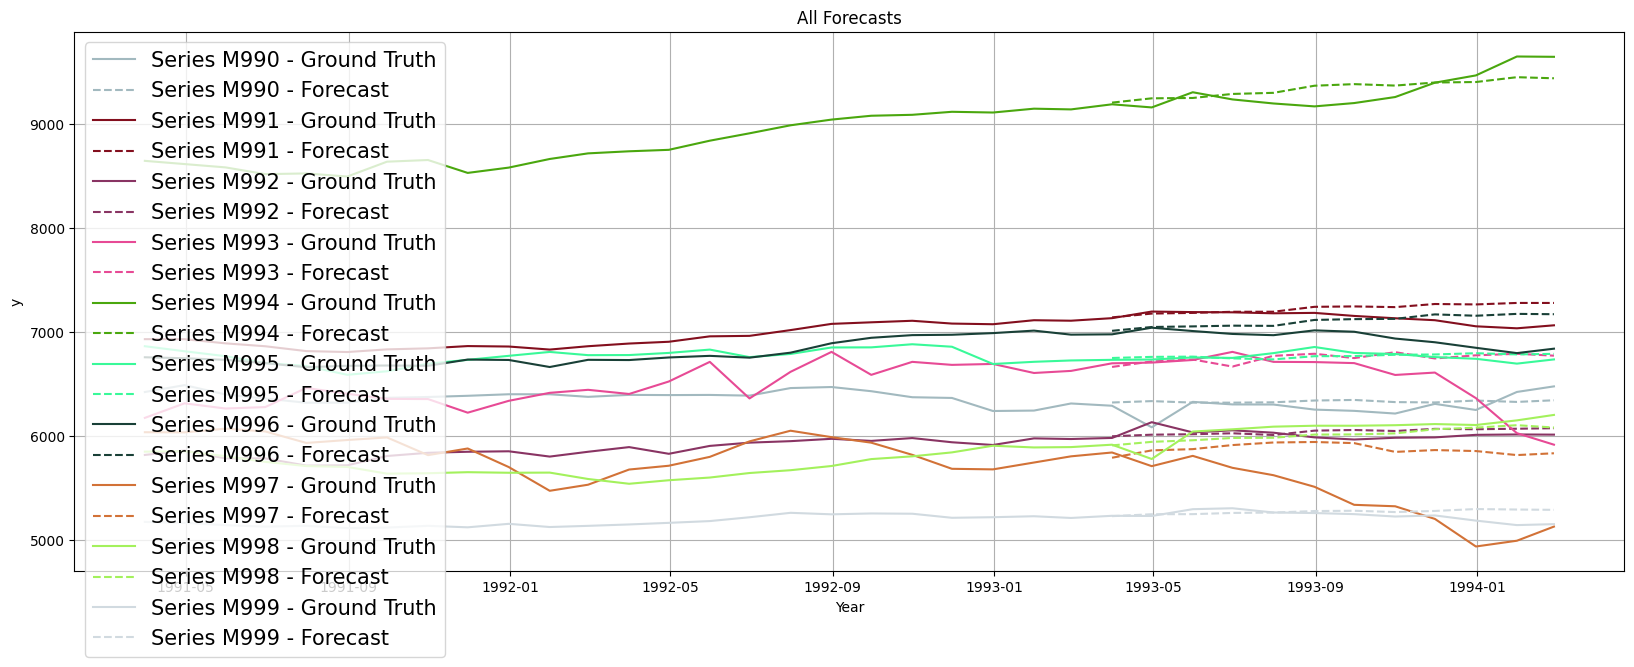


--- Evaluating for horizon: 18 ---


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | valid_loss   | SMAPE         | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
1.6 K     Non-trainable params
2.5 M     Total params
9.853     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode



>>> Running model: nbeats
Epoch 17:  78%|███████▊  | 35/45 [00:01<00:00, 19.25it/s, v_num=22, train_loss_step=0.107, train_loss_epoch=0.120, valid_loss=0.145] 


c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\utilsforecast\processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 136.02it/s]

Seed set to 1



Model 'nbeats' config 1: sMAPE = 0.139

>>> Running model: simpleMoe


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | valid_loss   | SMAPE         | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | dropout      | Dropout       | 0      | train
5 | experts      | ModuleList    | 2.7 K  | train
6 | gate         | Linear        | 150    | train
7 | softmax      | Softmax       | 0      | train
-------------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.011     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Epoch 57:  78%|███████▊  | 35/45 [00:00<00:00, 39.24it/s, v_num=24, train_loss_step=0.130, train_loss_epoch=0.153, valid_loss=0.152] 


c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\utilsforecast\processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 182.33it/s]

Seed set to 1



Model 'simpleMoe' config 1: sMAPE = 0.159

>>> Running model: nhits


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | valid_loss   | SMAPE         | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.771     Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Epoch 17:  78%|███████▊  | 35/45 [00:02<00:00, 16.85it/s, v_num=26, train_loss_step=0.110, train_loss_epoch=0.124, valid_loss=0.146] 


c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\utilsforecast\processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 143.88it/s]
Model 'nhits' config 1: sMAPE = 0.143
Mean sMAPE for horizon 18: 0.139


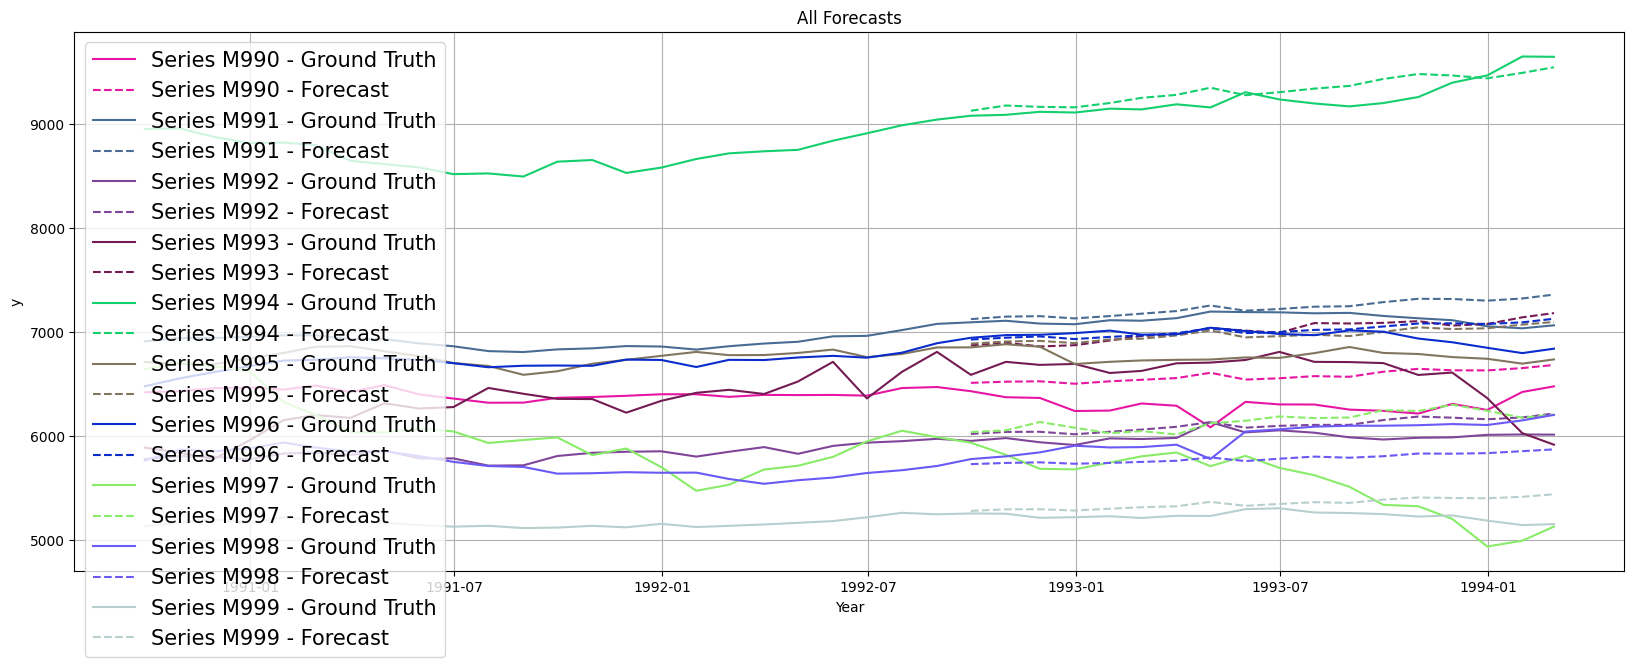


--- Evaluating for horizon: 24 ---


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | valid_loss   | SMAPE         | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
2.4 K     Non-trainable params
2.5 M     Total params
9.918     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode



>>> Running model: nbeats
Epoch 22:  22%|██▏       | 10/45 [00:00<00:03, 11.57it/s, v_num=28, train_loss_step=0.100, train_loss_epoch=0.132, valid_loss=0.161] 

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 22:  22%|██▏       | 10/45 [00:00<00:03, 11.53it/s, v_num=28, train_loss_step=0.100, train_loss_epoch=0.132, valid_loss=0.161]


c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\utilsforecast\processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 163.17it/s]
Model 'nbeats' config 2: sMAPE = 0.147

>>> Running model: simpleMoe


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | valid_loss   | SMAPE         | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | dropout      | Dropout       | 0      | train
5 | experts      | ModuleList    | 3.6 K  | train
6 | gate         | Linear        | 150    | train
7 | softmax      | Softmax       | 0      | train
-------------------------------------------------------
3.8 K     Trainable params
0         Non-trainable params
3.8 K     Total params
0.015     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Epoch 48:  89%|████████▉ | 40/45 [00:00<00:00, 41.57it/s, v_num=30, train_loss_step=0.122, train_loss_epoch=0.149, valid_loss=0.178] 


c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\utilsforecast\processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 163.76it/s]

Seed set to 1



Model 'simpleMoe' config 2: sMAPE = 0.161

>>> Running model: nhits


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | valid_loss   | SMAPE         | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.794     Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Epoch 22:  22%|██▏       | 10/45 [00:00<00:03, 11.17it/s, v_num=32, train_loss_step=0.104, train_loss_epoch=0.138, valid_loss=0.160] 

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 22:  22%|██▏       | 10/45 [00:00<00:03, 11.14it/s, v_num=32, train_loss_step=0.104, train_loss_epoch=0.138, valid_loss=0.160]


c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\utilsforecast\processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 153.18it/s]
Model 'nhits' config 2: sMAPE = 0.148
Mean sMAPE for horizon 24: 0.147


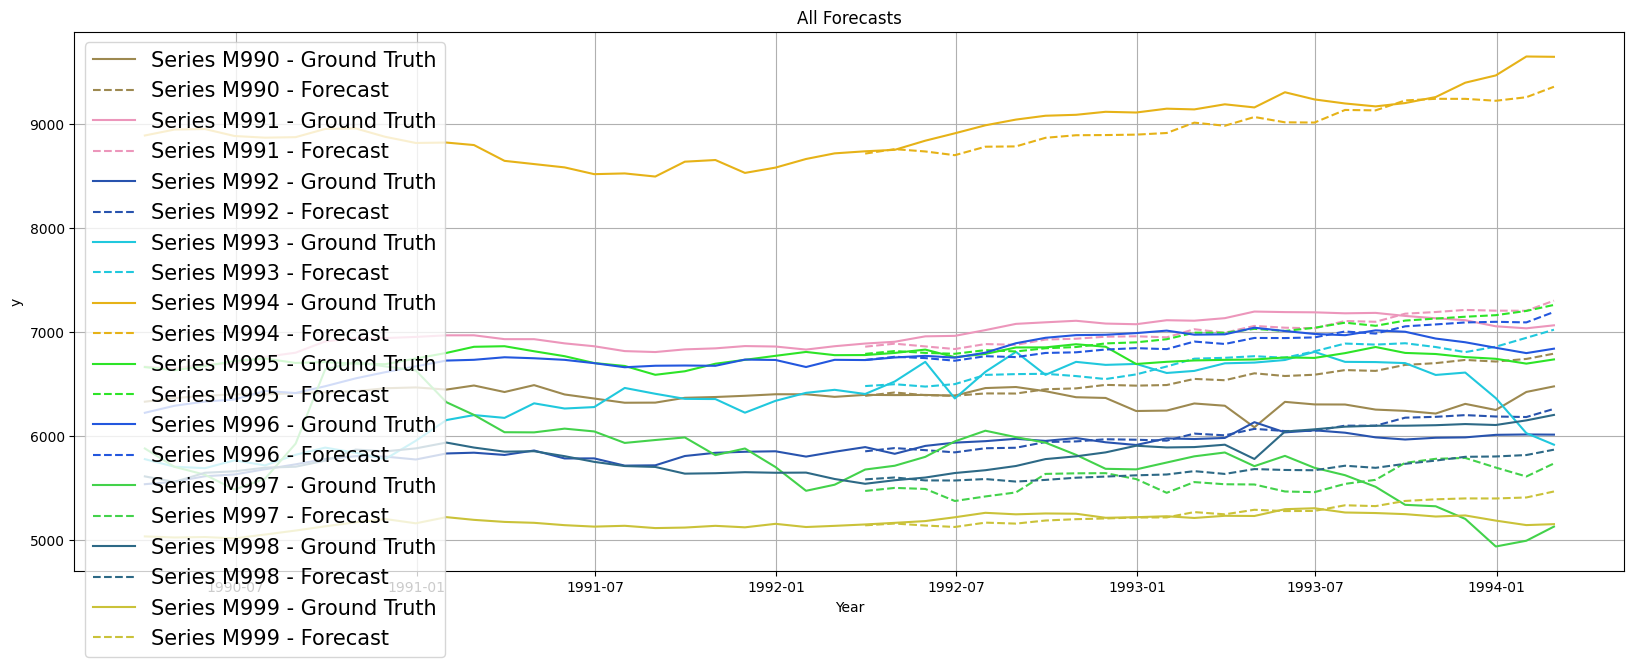

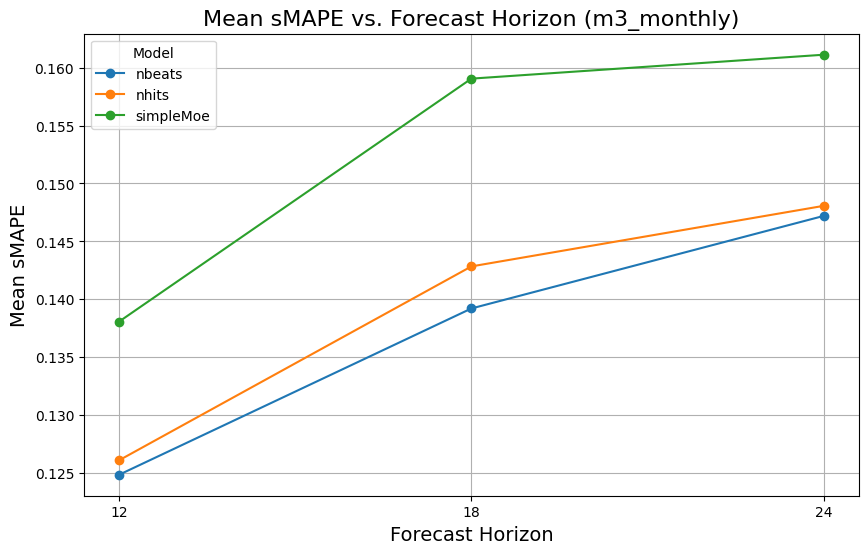

In [3]:
import run_exp as utils


def run_all_models():
    hydra.initialize(config_path="./../conf")
    cfg = hydra.compose(config_name="config.yaml")
    
    results = utils.run_exp(cfg)
    results.to_csv("results.csv", index=False)

    return results
results = run_all_models()

In [ ]:
from ray import tune

dic: DictConfig = DictConfig({
    'directory': './data/m3',
    'group': 'Monthly',
})

Y_all = utils.load_dataset('m3_monthly', dic)

# horizons: list = [i for i in range(1, 2)]
horizons: list = [12, 18, 24]
results = pd.DataFrame(columns=['model', 'horizon', 'smape'])

models = [
    # AutoDeepAR,
    # AutoNBEATS,
    AutoNHITS,
    # AutoTFT,
    # AutoTCN,
    # AutoRNN,
    # AutoLSTM
    # DeepAR,
    # NBEATS,
    # NHITS,
    # TFT,
    # TCN,
    # RNN,
    # LSTM
]


for modelCls in models:
    for horizon in horizons:

        
        print(f"Running {modelCls.__name__} with horizon {horizon}")


        # model = modelCls(
        #     h=horizon,
        #     input_size=24,
        #     loss=SMAPE(),
        #     early_stopping_patience=10,
        #     batch_size=32,
        #     valid_loss=SMAPE(),
        # )
        model = modelCls(
            num_samples = 5,
            loss=SMAPE(),
            h=horizon,
        )

        nf = NeuralForecast(
            models=[model],
            freq='M',
        )
        
        Y_hat = nf.cross_validation(df=Y_all, val_size=horizon)
        results = pd.concat([results, pd.DataFrame({
            'model': [model.__class__.__name__],
            'horizon': [horizon],
            'smape': [utils.calculate_smape(Y_hat, Y_hat, model.__class__.__name__)]
        })], ignore_index=True)

2025-02-12 00:20:29,769	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_23c8a_00000
Traceback (most recent call last):
  File "c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\ray\_private\worker.py", line 2772, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^

RuntimeError: No best trial found for the given metric: loss. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

In [4]:
results

,model,horizon,smape
0,nbeats,12,0.124858
1,simpleMoe,12,0.138079
2,nhits,12,0.126106
3,nbeats,18,0.139210
4,simpleMoe,18,0.159051
5,nhits,18,0.142841
6,nbeats,24,0.147199
7,simpleMoe,24,0.161115
8,nhits,24,0.148069


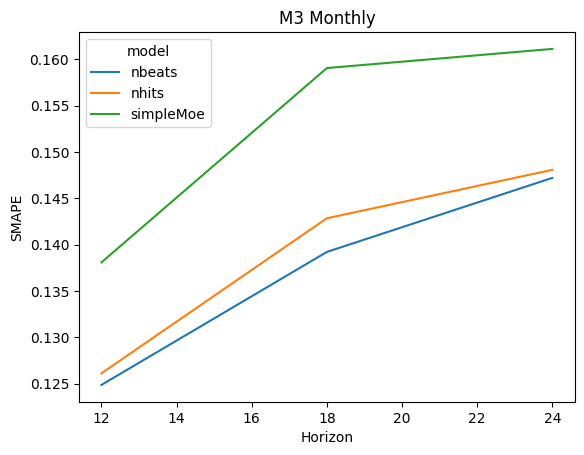

In [5]:
# show results in a graph

results = results.pivot(index='horizon', columns='model', values='smape')
results.plot()
plt.title('M3 Monthly')
plt.ylabel('SMAPE')
plt.xlabel('Horizon')
plt.show()
